# Coursera_capstone - relationship between income and preference in NYC

In [284]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


# 1. Import and clean data

#### 1. New York City median income, retrieved from Renthop :
######  $\;\;\;\;\;\;\;\;$ https://www.renthop.com/study/assets/new-york-city-cost-of-living-2017/nyc-2br-median-rent-and-income-table.html
#### They are converted into an excel file and are slightly modified by extracting only the median income column.

In [9]:
income_data = pd.read_excel(r'D:\download\NYC income.xlsx')
income_data.head()

Neighborhood    Borough Median Income
0  Queensbridge-Ravenswood-Long Island City     Queens       $28,378
1                              Williamsburg   Brooklyn       $21,502
2                           Lower East Side  Manhattan       $31,273
3                    Mott Haven-Port Morris      Bronx       $20,334
4                         East Harlem North  Manhattan       $26,099

In [12]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(income_data['Borough'].unique()),
        income_data.shape[0]
    )
)

The dataframe has 5 boroughs and 139 neighborhoods.


#### 2. New York City longitude & latitude data, retrieved from New York (City). Department of City Planning:
######  $\;\;\;\;\;\;\;\;$ https://geo.nyu.edu/catalog/nyu_2451_34572

In [10]:
with open(r'D:\download\nyu_2451_34572-geojson.json') as json_data:
    newyork_data = json.load(json_data)

In [11]:
neighborhoods_data = newyork_data['features']
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
neighborhoods.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

In [13]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### 3. Merge the above dataframes together

In [25]:
ny_merged = income_data.merge(neighborhoods.set_index('Neighborhood'),on='Neighborhood')
ny_merged.head()

Neighborhood  Borough_x Median Income  Borough_y   Latitude  Longitude
0     Williamsburg   Brooklyn       $21,502   Brooklyn  40.707144 -73.958115
1  Lower East Side  Manhattan       $31,273  Manhattan  40.717807 -73.980890
2        Chinatown  Manhattan       $35,908  Manhattan  40.715618 -73.994279
3   Manhattanville  Manhattan       $29,182  Manhattan  40.816934 -73.957385
4      Hunts Point      Bronx       $22,572      Bronx  40.809730 -73.883315

In [34]:
# Check the shape of the merged df
ny_merged.shape

(67, 6)

In [59]:
# Since the amount of data decreases a lot after the merging process, some has to be checked if the data are restorable

# these are the data loss in the merging process
problem_list = list(set(list(income_data['Neighborhood']))-(set(list(neighborhoods['Neighborhood']))))
problem_list

['East Concourse-Concourse Village',
 'Spuyten Duyvil-Kingsbridge',
 'Pomonok-Flushing Heights-Hillcrest',
 'East Flatbush-Farragut',
 'North Riverdale-Fieldston-Riverdale',
 'Murray Hill-Kips Bay',
 'West New Brighton-New Brighton-St. George',
 'East Harlem South',
 'New Dorp-Midland Beach',
 'Marble Hill-Inwood',
 'Brooklyn Heights-Cobble Hill',
 'Upper East Side-Carnegie Hill',
 'Van Nest-Morris Park-Westchester Square',
 'Bushwick South',
 'Ft. Totten-Bay Terrace-Clearview',
 'Mott Haven-Port Morris',
 'SoHo-TriBeCa-Civic Center-Little Italy',
 'Briarwood-Jamaica Hills',
 'Georgetown-Marine Park-Bergen Beach-Mill Basin',
 'Lenox Hill-Roosevelt Island',
 'Sunset Park West',
 'West Farms-Bronx River',
 'Central Harlem North-Polo Grounds',
 'DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill',
 'Stuyvesant Town-Cooper Village',
 'Hudson Yards-Chelsea-Flat Iron-Union Square',
 'West Concourse',
 'Crown Heights North',
 'Turtle Bay-East Midtown',
 'Crown Heights South',
 'Highbridge',
 'M

In [62]:
# It is found that many of the name after '-' appears in the neighborhoods df, for example
'Little Neck' in list(neighborhoods['Neighborhood'])

True

In [66]:
# To save those data, the name in the income_data df has to be cleaned for a bit
fixed_list=[]
for place in list(income_data['Neighborhood']):
    try:
        fixed_list.append(place.split('-')[-1])
    except:
        fixed_list.append(place)

fixed_list

['Long Island City',
 'Williamsburg',
 'Lower East Side',
 'Port Morris',
 'East Harlem North',
 'Chinatown',
 'Manhattanville',
 'Highbridge',
 'Hunts Point',
 'Mott Haven North',
 'Concourse Village',
 'Morris Heights',
 'East Harlem South',
 'East New York (Pennsylvania Ave)',
 'Fort Greene',
 'Mount Hope',
 'Brighton Beach',
 'West Brighton',
 'Bronx River',
 'Bedford',
 'Polo Grounds',
 'South Side',
 'Stuyvesant Heights',
 'Crown Heights North',
 'Jamaica',
 'Bushwick South',
 'West Maspeth',
 'Fordham North',
 'St. George',
 'Hamilton Heights',
 'Ocean Hill',
 'West Concourse',
 'Flushing',
 'Washington Heights South',
 'Central Harlem South',
 'Sunset Park East',
 'Rego Park',
 'Crown Heights South',
 'East Williamsburg',
 'Edgemere',
 'Old Astoria',
 'Bushwick North',
 'Wingate',
 'East New York',
 'Gravesend',
 'Morningside Heights',
 'Inwood',
 'Harding Park',
 'Borough Park',
 'Norwood',
 'Sunset Park West',
 'Corona',
 'Boerum Hill',
 'East Village',
 'Rosebank',
 'Flatbus

In [67]:
# check if all 139 neighborhoods name are converted successfully
len(fixed_list)

139

In [68]:
# All are converted successfully
# The names in the column of Neighborhood can be replaced
income_data['Neighborhood'] = fixed_list
income_data.head()

Neighborhood    Borough Median Income
0   Long Island City     Queens       $28,378
1       Williamsburg   Brooklyn       $21,502
2    Lower East Side  Manhattan       $31,273
3        Port Morris      Bronx       $20,334
4  East Harlem North  Manhattan       $26,099

In [70]:
# Now, do the merging again
ny_merged = income_data.merge(neighborhoods.set_index('Neighborhood'),on='Neighborhood')

# Check the shape of the merged df again
print(ny_merged.shape)

ny_merged.head()

(102, 6)


Neighborhood  Borough_x Median Income  Borough_y   Latitude  Longitude
0  Long Island City     Queens       $28,378     Queens  40.750217 -73.939202
1      Williamsburg   Brooklyn       $21,502   Brooklyn  40.707144 -73.958115
2   Lower East Side  Manhattan       $31,273  Manhattan  40.717807 -73.980890
3       Port Morris      Bronx       $20,334      Bronx  40.801664 -73.913221
4         Chinatown  Manhattan       $35,908  Manhattan  40.715618 -73.994279

#### Now we have 102 rows, which seems much better than the previous merge (67 rows).
#### Although there are originally 139 rows, the wasted data review less to no pattern that allow us to recover, therefore we can only move on.

In [73]:
# Drop borough_y column to make the merged df clearer
ny_merged.drop('Borough_y',1,inplace = True)
ny_merged.head()

Neighborhood  Borough_x Median Income   Latitude  Longitude
0  Long Island City     Queens       $28,378  40.750217 -73.939202
1      Williamsburg   Brooklyn       $21,502  40.707144 -73.958115
2   Lower East Side  Manhattan       $31,273  40.717807 -73.980890
3       Port Morris      Bronx       $20,334  40.801664 -73.913221
4         Chinatown  Manhattan       $35,908  40.715618 -73.994279

In [74]:
# rename Borough_x as Borough
ny_merged.rename(columns={'Borough_x':'Borough','Median Income':'Median Income in dollar'},inplace=True)

# drop the dollar sign in the income column
ny_merged['Median Income in dollar'] = ny_merged['Median Income in dollar'].str.replace('$','')

ny_merged.head()

Neighborhood    Borough Median Income in dollar   Latitude  Longitude
0  Long Island City     Queens                  28,378  40.750217 -73.939202
1      Williamsburg   Brooklyn                  21,502  40.707144 -73.958115
2   Lower East Side  Manhattan                  31,273  40.717807 -73.980890
3       Port Morris      Bronx                  20,334  40.801664 -73.913221
4         Chinatown  Manhattan                  35,908  40.715618 -73.994279

# 2. Explore the neighborhood

#### 1. Extract the data of neighborhood famous venues

In [ ]:
# Using Foursquare

CLIENT_ID = '4K5JXRL3MQCLAS1E510KPQSQOPWJG0ADJZ0SLB1COIYYO5HL' # your Foursquare ID
CLIENT_SECRET = 'IXALWRVAOHQWSQSCMEJ0A4QDUZBJMV2LMCOGQNCEAT0TZVIT' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

In [79]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [80]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

newyork_venues = getNearbyVenues(names=ny_merged['Neighborhood'],
                                   latitudes=ny_merged['Latitude'],
                                   longitudes=ny_merged['Longitude']
                                  )


Long Island City
Williamsburg
Lower East Side
Port Morris
Chinatown
Manhattanville
Hunts Point
Concourse Village
Morris Heights
Fort Greene
Mount Hope
Brighton Beach
West Brighton
South Side
St. George
Hamilton Heights
Ocean Hill
Flushing
Rego Park
East Williamsburg
Edgemere
Wingate
East New York
Gravesend
Morningside Heights
Inwood
Borough Park
Norwood
Corona
Boerum Hill
East Village
Rosebank
Flatbush
City Line
Midwood
Elmhurst
Clinton
North Corona
Westchester Square
Ocean Parkway
Erasmus
Jackson Heights
Cobble Hill
Pelham Parkway
Maspeth
Maspeth
Clinton Hill
Ridgewood
Astoria
Murray Hill
Murray Hill
College Point
Lincoln Square
Woodside
Remsen Village
Upper West Side
Port Richmond
Homecrest
Greenpoint
Manhattan Beach
Red Hook
Riverdale
Unionport
Queensboro Hill
Hillcrest
Bath Beach
Bay Ridge
Steinway
Gramercy
Kingsbridge
Madison
West Village
Jamaica Hills
Little Italy
Kew Gardens
Forest Hills
Dyker Heights
Prospect Heights
Richmond Hill
Windsor Terrace
South Ozone Park
Midtown South


In [81]:
newyork_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Long Island City              40.750217              -73.939202   
1  Long Island City              40.750217              -73.939202   
2  Long Island City              40.750217              -73.939202   
3  Long Island City              40.750217              -73.939202   
4  Long Island City              40.750217              -73.939202   

                                               Venue  Venue Latitude  \
0  Hilton Garden Inn New York Long Island City/Ma...       40.750216   
1                                  Etto Espresso Bar       40.748703   
2                                 Baker House Market       40.752137   
3                                   The Baroness Bar       40.751582   
4                                        Dutch Kills       40.747830   

   Venue Longitude     Venue Category  
0       -73.936886              Hotel  
1       -73.940689        Coffee Shop  
2       -73.939235  Convenience Store  
3       -73.939664                Bar  
4       -73.940108       Cocktail Bar

#### 2. Analyzing the venue data

In [83]:
# one hot encoding
newyork_onehot = pd.get_dummies(newyork_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
newyork_onehot['Neighborhood'] = newyork_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = ['Neighborhood'] + list(newyork_onehot.loc[:,newyork_onehot.columns != 'Neighborhood'])
newyork_onehot = newyork_onehot[fixed_columns]

newyork_onehot.head()

Neighborhood  Accessories Store  Afghan Restaurant  \
0  Long Island City                  0                  0   
1  Long Island City                  0                  0   
2  Long Island City                  0                  0   
3  Long Island City                  0                  0   
4  Long Island City                  0                  0   

   American Restaurant  Antique Shop  Arcade  Arepa Restaurant  \
0                    0             0       0                 0   
1                    0             0       0                 0   
2                    0             0       0                 0   
3                    0             0       0                 0   
4                    0             0       0                 0   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                       0            0           0                    0   
1                       0            0           0                    0   
2                       0            0           0                    0   
3                       0            0           0                    0   
4                       0            0           0                    0   

   Arts & Entertainment  Asian Restaurant  Athletics & Sports  \
0                     0                 0                   0   
1                     0                 0                   0   
2                     0                 0                   0   
3                     0                 0                   0   
4                     0                 0                   0   

   Australian Restaurant  Austrian Restaurant  Auto Workshop  Automotive Shop  \
0                      0                    0              0                0   
1                      0                    0              0                0   
2                      0                    0              0                0   
3                      0                    0              0                0   
4                      0                    0              0                0   

   BBQ Joint  Bagel Shop  Bakery  Bank  Bar  Baseball Field  Baseball Stadium  \
0          0           0       0     0    0               0                 0   
1          0           0       0     0    0               0                 0   
2          0           0       0     0    0               0                 0   
3          0           0       0     0    1               0                 0   
4          0           0       0     0    0               0                 0   

   Basketball Court  Bath House  Beach  Bed & Breakfast  Beer Bar  \
0                 0           0      0                0         0   
1                 0           0      0                0         0   
2                 0           0      0                0         0   
3                 0           0      0                0         0   
4                 0           0      0                0         0   

   Beer Garden  Beer Store  Big Box Store  Bike Rental / Bike Share  \
0            0           0              0                         0   
1            0           0              0                         0   
2            0           0              0                         0   
3            0           0              0                         0   
4            0           0              0                         0   

   Bike Shop  Bike Trail  Bistro  Board Shop  Bookstore  Boutique  \
0          0           0       0           0          0         0   
1          0           0       0           0          0         0   
2          0           0       0           0          0         0   
3          0           0       0           0          0         0   
4          0           0       0           0          0         0   

   Bowling Alley  Boxing Gym  Brazilian Restaurant  Breakfast Spot  Brewery  \
0              0           0                     0               0        0   
1           

In [84]:
# group rows by neighborhood by taking the means
newyork_onehot.reset_index()
newyork_grouped = newyork_onehot.groupby('Neighborhood').mean()
newyork_grouped.reset_index(inplace=True)
newyork_grouped.head()

Neighborhood  Accessories Store  Afghan Restaurant  American Restaurant  \
0      Astoria                0.0                0.0             0.000000   
1   Auburndale                0.0                0.0             0.058824   
2   Bath Beach                0.0                0.0             0.000000   
3    Bay Ridge                0.0                0.0             0.033708   
4  Boerum Hill                0.0                0.0             0.011111   

   Antique Shop  Arcade  Arepa Restaurant  Argentinian Restaurant  \
0      0.000000     0.0               0.0                     0.0   
1      0.000000     0.0               0.0                     0.0   
2      0.000000     0.0               0.0                     0.0   
3      0.000000     0.0               0.0                     0.0   
4      0.011111     0.0               0.0                     0.0   

   Art Gallery  Art Museum  Arts & Crafts Store  Arts & Entertainment  \
0          0.0         0.0             0.000000                   0.0   
1          0.0         0.0             0.000000                   0.0   
2          0.0         0.0             0.000000                   0.0   
3          0.0         0.0             0.000000                   0.0   
4          0.0         0.0             0.022222                   0.0   

   Asian Restaurant  Athletics & Sports  Australian Restaurant  \
0          0.000000            0.000000                    0.0   
1          0.000000            0.058824                    0.0   
2          0.020000            0.000000                    0.0   
3          0.011236            0.000000                    0.0   
4          0.000000            0.011111                    0.0   

   Austrian Restaurant  Auto Workshop  Automotive Shop  BBQ Joint  Bagel Shop  \
0                  0.0            0.0              0.0       0.01    0.010000   
1                  0.0            0.0              0.0       0.00    0.000000   
2                  0.0            0.0              0.0       0.00    0.020000   
3                  0.0            0.0              0.0       0.00    0.033708   
4                  0.0            0.0              0.0       0.00    0.000000   

     Bakery      Bank       Bar  Baseball Field  Baseball Stadium  \
0  0.030000  0.000000  0.060000             0.0               0.0   
1  0.000000  0.000000  0.000000             0.0               0.0   
2  0.020000  0.020000  0.000000             0.0               0.0   
3  0.000000  0.000000  0.033708             0.0               0.0   
4  0.022222  0.011111  0.033333             0.0               0.0   

   Basketball Court  Bath House  Beach  Bed & Breakfast  Beer Bar  \
0               0.0         0.0    0.0              0.0       0.0   
1               0.0         0.0    0.0              0.0       0.0   
2               0.0         0.0    0.0              0.0       0.0   
3               0.0         0.0    0.0              0.0       0.0   
4               0.0         0.0    0.0              0.0       0.0   

   Beer Garden  Beer Store  Big Box Store  Bike Rental / Bike Share  \
0         0.01         0.0            0.0                       0.0   
1         0.00         0.0            0.0                       0.0   
2         0.00         0.0            0.0                       0.0   
3         0.00         0.0            0.0                       0.0   
4         0.00         0.0            0.0                       0.0   

   Bike Shop  Bike Trail  Bistro  Board Shop  Bookstore  Boutique  \
0        0.0         0.0     0.0         0.0   0.000000  0.000000   
1        0.0         0.0     0.0         0.0   0.000000  0.000000   
2        0.0         0.0     0.0         0.0   0.000000  0.000000   
3        0.0         0.0     0.0         0.0   0.011236  0.000000   
4        0.0         0.0     0.0         0.0   0.011111  0.011111   

   Bowling Alley  Boxing Gym  Brazilian Restaurant  Breakfast Spot  Brewery  \
0            0.0         0.0                  0.01

In [85]:
# rank the top 10 venues in each neighborhood
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = newyork_grouped['Neighborhood']

for ind in np.arange(newyork_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(newyork_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood      1st Most Common Venue 2nd Most Common Venue  \
0      Astoria  Middle Eastern Restaurant                   Bar   
1   Auburndale         Miscellaneous Shop    Athletics & Sports   
2   Bath Beach                   Pharmacy         Deli / Bodega   
3    Bay Ridge         Italian Restaurant                   Spa   
4  Boerum Hill                Coffee Shop          Dance Studio   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0            Hookah Bar      Greek Restaurant    Seafood Restaurant   
1        Discount Store              Pharmacy             Pet Store   
2            Donut Shop    Chinese Restaurant            Kids Store   
3      Greek Restaurant   American Restaurant           Pizza Place   
4                   Spa                   Bar        Sandwich Place   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0                Bakery    Italian Restaurant    Salon / Barbershop   
1          Noodle House  Fast Food Restaurant     Mobile Phone Shop   
2    Italian Restaurant       Bubble Tea Shop      Sushi Restaurant   
3                   Bar            Bagel Shop         Grocery Store   
4     Martial Arts Dojo     French Restaurant                Bakery   

      9th Most Common Venue 10th Most Common Venue  
0  Mediterranean Restaurant      Food & Drink Shop  
1    Furniture / Home Store      Korean Restaurant  
2      Fast Food Restaurant        Supplement Shop  
3            Sandwich Place       Sushi Restaurant  
4             Grocery Store   Gym / Fitness Center

#### 3. Putting all the data together

In [88]:
final_df = ny_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood').iloc[:,:5],on='Neighborhood')
final_df.head()

Neighborhood    Borough Median Income in dollar   Latitude  Longitude  \
0  Long Island City     Queens                  28,378  40.750217 -73.939202   
1      Williamsburg   Brooklyn                  21,502  40.707144 -73.958115   
2   Lower East Side  Manhattan                  31,273  40.717807 -73.980890   
3       Port Morris      Bronx                  20,334  40.801664 -73.913221   
4         Chinatown  Manhattan                  35,908  40.715618 -73.994279   

  1st Most Common Venue      2nd Most Common Venue 3rd Most Common Venue  \
0                 Hotel                Coffee Shop    Mexican Restaurant   
1            Bagel Shop                Coffee Shop                   Bar   
2           Coffee Shop                       Café    Chinese Restaurant   
3      Storage Facility  Latin American Restaurant            Restaurant   
4    Chinese Restaurant               Cocktail Bar    Salon / Barbershop   

  4th Most Common Venue  5th Most Common Venue  
0           Pizza Place                   Café  
1           Yoga Studio             Steakhouse  
2      Ramen Restaurant            Pizza Place  
3            Distillery             Donut Shop  
4   American Restaurant  Vietnamese Restaurant

In [90]:
# a little check about the df again
final_df.shape

(102, 10)

# 3. Analyze the relationship between income and common venue

In [104]:
# drop the comma in the income column
final_df['Median Income in dollar'] = final_df['Median Income in dollar'].str.replace(',','')
final_df['Median Income in dollar'] = final_df['Median Income in dollar'].astype(int)

# sort df by income
final_df.sort_values(by='Median Income in dollar',ascending = True, inplace = True)
final_df.head()

Neighborhood   Borough  Median Income in dollar   Latitude  Longitude  \
3      Port Morris     Bronx                    20334  40.801664 -73.913221   
1     Williamsburg  Brooklyn                    21502  40.707144 -73.958115   
6      Hunts Point     Bronx                    22572  40.809730 -73.883315   
8   Morris Heights     Bronx                    25073  40.847898 -73.919672   
10      Mount Hope     Bronx                    26195  40.848842 -73.908299   

   1st Most Common Venue      2nd Most Common Venue 3rd Most Common Venue  \
3       Storage Facility  Latin American Restaurant            Restaurant   
1             Bagel Shop                Coffee Shop                   Bar   
6         Waste Facility         Spanish Restaurant            Restaurant   
8          Deli / Bodega                Bus Station                  Bank   
10      Asian Restaurant                Supermarket        Sandwich Place   

   4th Most Common Venue 5th Most Common Venue  
3             Distillery            Donut Shop  
1            Yoga Studio            Steakhouse  
6           Gourmet Shop        Shipping Store  
8     Chinese Restaurant  Fast Food Restaurant  
10            Donut Shop         Metro Station

#### 1. Separate the neighborhood into 3 groups (low, moderate, high income)

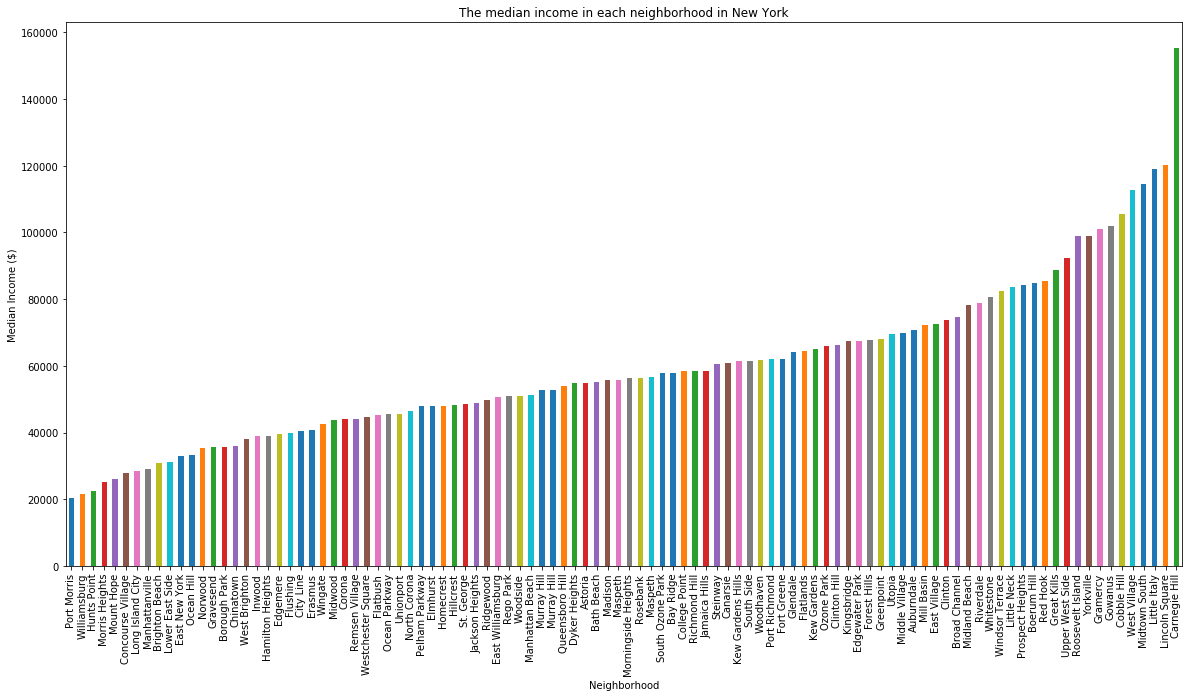

In [115]:
# Let's see if we can saparate it easily
final_df.reset_index(inplace=True)
# step 1: get the data
df_income_in_neigh = final_df.set_index('Neighborhood').iloc[:, 3]

# step 2: plot data
df_income_in_neigh.plot(kind='bar', figsize=(20, 10))

plt.xlabel('Neighborhood') # add to x-label to the plot
plt.ylabel('Median Income ($)') # add y-label to the plot
plt.title('The median income in each neighborhood in New York') # add title to the plot

plt.show()

#### As depicted on the graph, the income can hardly be segmented into 3 groups (low, moderate, high income) clearly. Thus, K-means clustering is used for the income column in order to separate those neighborhoods rationally.

In [142]:
income_clustering = final_df[['Median Income in dollar']]

# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(income_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [146]:
# add clustering labels
final_df.insert(0, 'Cluster Labels', kmeans.labels_)
final_df.tail()

Cluster Labels    Neighborhood    Borough  Median Income in dollar  \
97                1    West Village  Manhattan                   112689   
98                1   Midtown South  Manhattan                   114491   
99                1    Little Italy  Manhattan                   118931   
100               1  Lincoln Square  Manhattan                   120337   
101               1   Carnegie Hill  Manhattan                   155213   

      Latitude  Longitude 1st Most Common Venue    2nd Most Common Venue  \
97   40.734434 -74.006180    Italian Restaurant  New American Restaurant   
98   40.748510 -73.988713     Korean Restaurant                    Hotel   
99   40.719324 -73.997305                Bakery                     Café   
100  40.773529 -73.985338  Gym / Fitness Center                  Theater   
101  40.782683 -73.953256           Coffee Shop              Pizza Place   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
97                   Park              Wine Bar   American Restaurant  
98    Japanese Restaurant             Hotel Bar          Dessert Shop  
99     Salon / Barbershop        Sandwich Place        Ice Cream Shop  
100                  Café                 Plaza          Concert Hall  
101                  Café           Yoga Studio    Italian Restaurant

In [444]:
final_df['Income Group'].astype('str',inplace = True)
final_df['Income Group'] = final_df['Income Group'].replace([0,1,2],['Low','High','Moderate'])

In [445]:
final_df.rename(columns={'Cluster Labels':'Income Level'},inplace=True)
final_df.tail()

Income Group    Neighborhood    Borough  Median Income in dollar  \
97          High    West Village  Manhattan                   112689   
98          High   Midtown South  Manhattan                   114491   
99          High    Little Italy  Manhattan                   118931   
100         High  Lincoln Square  Manhattan                   120337   
101         High   Carnegie Hill  Manhattan                   155213   

      Latitude  Longitude 1st Most Common Venue    2nd Most Common Venue  \
97   40.734434 -74.006180    Italian Restaurant  New American Restaurant   
98   40.748510 -73.988713     Korean Restaurant                    Hotel   
99   40.719324 -73.997305                Bakery                     Café   
100  40.773529 -73.985338  Gym / Fitness Center                  Theater   
101  40.782683 -73.953256           Coffee Shop              Pizza Place   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
97                   Park              Wine Bar   American Restaurant  
98    Japanese Restaurant             Hotel Bar          Dessert Shop  
99     Salon / Barbershop        Sandwich Place        Ice Cream Shop  
100                  Café                 Plaza          Concert Hall  
101                  Café           Yoga Studio    Italian Restaurant

#### 2. Count the number of appearence of each venues in each Income Group in the top 5 list

In [164]:
# another hot coding
dummies = pd.get_dummies(final_df[['1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue','4th Most Common Venue','5th Most Common Venue']], prefix="", prefix_sep="")
final_df_with_dummies = pd.concat([final_df.drop(['1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue','4th Most Common Venue','5th Most Common Venue'],1),dummies],axis=1)

In [165]:
final_df_with_dummies.head()

Income Group    Neighborhood   Borough  Median Income in dollar   Latitude  \
0          Low     Port Morris     Bronx                    20334  40.801664   
1          Low    Williamsburg  Brooklyn                    21502  40.707144   
2          Low     Hunts Point     Bronx                    22572  40.809730   
3          Low  Morris Heights     Bronx                    25073  40.847898   
4          Low      Mount Hope     Bronx                    26195  40.848842   

   Longitude  Asian Restaurant  Bagel Shop  Bakery  Bank  Bar  Beach  \
0 -73.913221                 0           0       0     0    0      0   
1 -73.958115                 0           1       0     0    0      0   
2 -73.883315                 0           0       0     0    0      0   
3 -73.919672                 0           0       0     0    0      0   
4 -73.908299                 1           0       0     0    0      0   

   Bookstore  Brewery  Bus Stop  Café  Caribbean Restaurant  \
0          0        0         0     0                     0   
1          0        0         0     0                     0   
2          0        0         0     0                     0   
3          0        0         0     0                     0   
4          0        0         0     0                     0   

   Chinese Restaurant  Clothing Store  Coffee Shop  Deli / Bodega  Donut Shop  \
0                   0               0            0              0           0   
1                   0               0            0              0           0   
2                   0               0            0              0           0   
3                   0               0            0              1           0   
4                   0               0            0              0           0   

   Fast Food Restaurant  Fried Chicken Joint  Grocery Store  Gym  \
0                     0                    0              0    0   
1                     0                    0              0    0   
2                     0                    0              0    0   
3                     0                    0              0    0   
4                     0                    0              0    0   

   Gym / Fitness Center  Hotel  Italian Restaurant  Korean Restaurant  \
0                     0      0                   0                  0   
1                     0      0                   0                  0   
2                     0      0                   0                  0   
3                     0      0                   0                  0   
4                     0      0                   0                  0   

   Latin American Restaurant  Metro Station  Mexican Restaurant  \
0                          0              0                   0   
1                          0              0                   0   
2                          0              0                   0   
3                          0              0                   0   
4                          0              0                   0   

   Middle Eastern Restaurant  Miscellaneous Shop  Moving Target  Park  \
0                          0                   0              0     0   
1                          0                   0              0     0   
2                          0                   0              0     0   
3                          0                   0              0     0   
4                          0                   0              0     0   

   Pharmacy  Pizza Place  Playground  Rental Car Location  Sandwich Place  \
0         0            0           0                    0               0   
1         0            0           0                    0               0   
2         0            0           0                    0               0   
3         0            0           0                    0               0   
4         0            0           0                    0               0   

   Seafood Restaurant  Sports Bar  Steakhouse  Storage Facility  \
0 

In [170]:
# start counting
group_final_df = final_df_with_dummies.groupby('Income Group').sum()
group_final_df = group_final_df.drop(['Median Income in dollar','Latitude','Longitude'],1)
group_final_df.head()

Asian Restaurant  Bagel Shop  Bakery  Bank  Bar  Beach  \
Income Group                                                           
High                         0           0       1     0    1      0   
Low                          1           1       1     2    1      1   
Moderate                     0           1       0     2    5      0   

              Bookstore  Brewery  Bus Stop  Café  Caribbean Restaurant  \
Income Group                                                             
High                  0        0         0     0                     0   
Low                   0        0         1     1                     2   
Moderate              1        1         0     0                     1   

              Chinese Restaurant  Clothing Store  Coffee Shop  Deli / Bodega  \
Income Group                                                                   
High                           0               0            1              0   
Low                            2               1            2              7   
Moderate                       3               0            1              8   

              Donut Shop  Fast Food Restaurant  Fried Chicken Joint  \
Income Group                                                          
High                   0                     0                    0   
Low                    3                     1                    0   
Moderate               0                     0                    1   

              Grocery Store  Gym  Gym / Fitness Center  Hotel  \
Income Group                                                    
High                      0    1                     1      0   
Low                       2    0                     0      1   
Moderate                  1    0                     1      0   

              Italian Restaurant  Korean Restaurant  \
Income Group                                          
High                           3                  1   
Low                            1                  2   
Moderate                       4                  0   

              Latin American Restaurant  Metro Station  Mexican Restaurant  \
Income Group                                                                 
High                                  0              0                   0   
Low                                   1              1                   2   
Moderate                              0              0                   0   

              Middle Eastern Restaurant  Miscellaneous Shop  Moving Target  \
Income Group                                                                 
High                                  0                   0              0   
Low                                   0                   0              0   
Moderate                              1                   1              1   

              Park  Pharmacy  Pizza Place  Playground  Rental Car Location  \
Income Group                                                                 
High             0         0            2           0                    0   
Low              0         0            3           0                    0   
Moderate         1         2            4           1                    1   

              Sandwich Place  Seafood Restaurant  Sports Bar  Steakhouse  \
Income Group                                                               
High                       1                   0           0           0   
Low                        0                   1           0           1   
Moderate                   0                   1           1           0   

              Storage Facility  Thai Restaurant  Theater  Waste Facility  \
Income Group                                                               
High                         0                0        0               0   
Low                          1                1        0               1   
Moderate                     0                0        1         

In [182]:
group_final_df.drop(['level_0','index'],1,inplace=True)

In [185]:
group_final_df = group_final_df.T

In [187]:
group_final_df.columns = group_final_df.iloc[0]
group_final_df

Income Group                     High  Low  Moderate
Income Group                     High  Low  Moderate
Asian Restaurant                    0    1         0
Bagel Shop                          0    1         1
Bakery                              1    1         0
Bank                                0    2         2
Bar                                 1    1         5
Beach                               0    1         0
Bookstore                           0    0         1
Brewery                             0    0         1
Bus Stop                            0    1         0
Café                                0    1         0
Caribbean Restaurant                0    2         1
Chinese Restaurant                  0    2         3
Clothing Store                      0    1         0
Coffee Shop                         1    2         1
Deli / Bodega                       0    7         8
Donut Shop                          0    3         0
Fast Food Restaurant                0    1         0
Fried Chicken Joint                 0    0         1
Grocery Store                       0    2         1
Gym                                 1    0         0
Gym / Fitness Center                1    0         1
Hotel                               0    1         0
Italian Restaurant                  3    1         4
Korean Restaurant                   1    2         0
Latin American Restaurant           0    1         0
Metro Station                       0    1         0
Mexican Restaurant                  0    2         0
Middle Eastern Restaurant           0    0         1
Miscellaneous Shop                  0    0         1
Moving Target                       0    0         1
Park                                0    0         1
Pharmacy                            0    0         2
Pizza Place                         2    3         4
Playground                          0    0         1
Rental Car Location                 0    0         1
Sandwich Place                      1    0         0
Seafood Restaurant                  0    1         1
Sports Bar                          0    0         1
Steakhouse                          0    1         0
Storage Facility                    0    1         0
Thai Restaurant                     0    1         0
Theater                             0    0         1
Waste Facility                      0    1         0
American Restaurant                 1    0         1
Art Gallery                         0    0         1
Arts & Crafts Store                 0    0         1
Athletics & Sports                  0    0         1
Bakery                              0    0         1
Bank                                0    1         1
Bar                                 1    1         1
Bubble Tea Shop                     0    1         0
Bus Station                         0    1         3
Bus Stop                            0    1         1
Café                                1    2         0
Caribbean Restaurant                0    0         1
Chinese Restaurant                  0    0         1
Cocktail Bar                        0    1         1
Coffee Shop                         1    5         1
Convenience Store                   0    1         0
Cosmetics Shop                      0    0         1
Dance Studio                        0    0         2
Deli / Bodega                       0    1         4
Diner                               0    0         2
Eastern European Restaurant         0    1         0
Fast Food Restaurant                0    4         1
Flower Shop                         0    0         1
Food Truck                          0    1         0
Fried Chicken Joint                 0    0         1
Furniture / Home Store              1    0         0
Grocery Store                       0    3         0
Gym                                 0    0         1
Gym / Fitness Center                0    1         1
Hotel                               1    0         0
Ice Cream Shop           

In [194]:
group_final_df.rename(columns={'Income Group':'Venue'},inplace = True)
group_final_df.drop('Income Group',0,inplace=True)
group_final_df

Income Group                    High Low Moderate
Asian Restaurant                   0   1        0
Bagel Shop                         0   1        1
Bakery                             1   1        0
Bank                               0   2        2
Bar                                1   1        5
Beach                              0   1        0
Bookstore                          0   0        1
Brewery                            0   0        1
Bus Stop                           0   1        0
Café                               0   1        0
Caribbean Restaurant               0   2        1
Chinese Restaurant                 0   2        3
Clothing Store                     0   1        0
Coffee Shop                        1   2        1
Deli / Bodega                      0   7        8
Donut Shop                         0   3        0
Fast Food Restaurant               0   1        0
Fried Chicken Joint                0   0        1
Grocery Store                      0   2        1
Gym                                1   0        0
Gym / Fitness Center               1   0        1
Hotel                              0   1        0
Italian Restaurant                 3   1        4
Korean Restaurant                  1   2        0
Latin American Restaurant          0   1        0
Metro Station                      0   1        0
Mexican Restaurant                 0   2        0
Middle Eastern Restaurant          0   0        1
Miscellaneous Shop                 0   0        1
Moving Target                      0   0        1
Park                               0   0        1
Pharmacy                           0   0        2
Pizza Place                        2   3        4
Playground                         0   0        1
Rental Car Location                0   0        1
Sandwich Place                     1   0        0
Seafood Restaurant                 0   1        1
Sports Bar                         0   0        1
Steakhouse                         0   1        0
Storage Facility                   0   1        0
Thai Restaurant                    0   1        0
Theater                            0   0        1
Waste Facility                     0   1        0
American Restaurant                1   0        1
Art Gallery                        0   0        1
Arts & Crafts Store                0   0        1
Athletics & Sports                 0   0        1
Bakery                             0   0        1
Bank                               0   1        1
Bar                                1   1        1
Bubble Tea Shop                    0   1        0
Bus Station                        0   1        3
Bus Stop                           0   1        1
Café                               1   2        0
Caribbean Restaurant               0   0        1
Chinese Restaurant                 0   0        1
Cocktail Bar                       0   1        1
Coffee Shop                        1   5        1
Convenience Store                  0   1        0
Cosmetics Shop                     0   0        1
Dance Studio                       0   0        2
Deli / Bodega                      0   1        4
Diner                              0   0        2
Eastern European Restaurant        0   1        0
Fast Food Restaurant               0   4        1
Flower Shop                        0   0        1
Food Truck                         0   1        0
Fried Chicken Joint                0   0        1
Furniture / Home Store             1   0        0
Grocery Store                      0   3        0
Gym                                0   0        1
Gym / Fitness Center               0   1        1
Hotel                              1   0        0
Ice Cream Shop                     0   1        0
Indian Restaurant                  0   0        1
Italian Restaurant                 2   1        1
Korean Restaurant                  0   0        1
Latin American Restaurant          0   2        0
Lounge                             0   0        1


In [204]:
group_final_df.drop('level_0',1,inplace=True)
group_final_df.rename(columns={'index':'Venue'},inplace = True)
group_final_df

Income Group                            Venue High Low Moderate
0                            Asian Restaurant    0   1        0
1                                  Bagel Shop    0   1        1
2                                      Bakery    1   1        0
3                                        Bank    0   2        2
4                                         Bar    1   1        5
5                                       Beach    0   1        0
6                                   Bookstore    0   0        1
7                                     Brewery    0   0        1
8                                    Bus Stop    0   1        0
9                                        Café    0   1        0
10                       Caribbean Restaurant    0   2        1
11                         Chinese Restaurant    0   2        3
12                             Clothing Store    0   1        0
13                                Coffee Shop    1   2        1
14                              Deli / Bodega    0   7        8
15                                 Donut Shop    0   3        0
16                       Fast Food Restaurant    0   1        0
17                        Fried Chicken Joint    0   0        1
18                              Grocery Store    0   2        1
19                                        Gym    1   0        0
20                       Gym / Fitness Center    1   0        1
21                                      Hotel    0   1        0
22                         Italian Restaurant    3   1        4
23                          Korean Restaurant    1   2        0
24                  Latin American Restaurant    0   1        0
25                              Metro Station    0   1        0
26                         Mexican Restaurant    0   2        0
27                  Middle Eastern Restaurant    0   0        1
28                         Miscellaneous Shop    0   0        1
29                              Moving Target    0   0        1
30                                       Park    0   0        1
31                                   Pharmacy    0   0        2
32                                Pizza Place    2   3        4
33                                 Playground    0   0        1
34                        Rental Car Location    0   0        1
35                             Sandwich Place    1   0        0
36                         Seafood Restaurant    0   1        1
37                                 Sports Bar    0   0        1
38                                 Steakhouse    0   1        0
39                           Storage Facility    0   1        0
40                            Thai Restaurant    0   1        0
41                                    Theater    0   0        1
42                             Waste Facility    0   1        0
43                        American Restaurant    1   0        1
44                                Art Gallery    0   0        1
45                        Arts & Crafts Store    0   0        1
46                         Athletics & Sports    0   0        1
47                                     Bakery    0   0        1
48                                       Bank    0   1        1
49                                        Bar    1   1        1
50                            Bubble Tea Shop    0   1        0
51                                Bus Station    0   1        3
52                                   Bus Stop    0   1        1
53                                       Café    1   2        0
54                       Caribbean Restaurant    0   0        1
55                         Chinese Restaurant    0   0        1
56                               Cocktail Bar    0   1        1
57                                Coffee Shop    1   5        1
58                          Convenience Store    0   1        0
59                             Cosmetics Shop    0   0        1
60                               Dance Studio    0   0        2
61                              

In [213]:
# Problem occurs, there are duplicate rows. The following codes are to fix this problem
aggregate_df = pd.pivot_table(group_final_df, index=['Venue'],values=['High','Low','Moderate'],aggfunc='sum')
aggregate_df.sort_values(by='High',inplace=True)
aggregate_df

Income Group                     High  Low  Moderate
Venue                                               
Hookah Bar                          0    0         1
South American Restaurant           0    1         1
Indian Restaurant                   0    0         2
Southern / Soul Food Restaurant     0    1         0
Hotpot Restaurant                   0    1         0
Spa                                 0    0         4
Spanish Restaurant                  0    2         0
Wine Shop                           0    0         3
Home Service                        0    0         1
Hobby Shop                          0    0         1
Harbor / Marina                     0    1         0
Sports Bar                          0    0         1
Steakhouse                          0    2         0
Grocery Store                       0    7         5
Greek Restaurant                    0    1         2
Gourmet Shop                        0    1         1
Gift Shop                           0    1         1
Storage Facility                    0    1         0
Frozen Yogurt Shop                  0    1         0
Fried Chicken Joint                 0    0         2
Shoe Store                          0    1         0
Juice Bar                           0    1         0
Kids Store                          0    0         1
Shipping Store                      0    1         0
Rental Car Location                 0    0         2
Playground                          0    1         2
Restaurant                          0    3         4
Pilates Studio                      0    0         1
Russian Restaurant                  0    1         0
Pet Store                           0    0         1
Peruvian Restaurant                 0    1         0
Sake Bar                            0    1         0
Other Nightlife                     0    0         1
Food Truck                          0    2         0
Moving Target                       0    0         1
Miscellaneous Shop                  0    0         1
Middle Eastern Restaurant           0    1         1
Mexican Restaurant                  0    8         5
Metro Station                       0    2         0
Seafood Restaurant                  0    1         2
Martial Arts Dojo                   0    1         1
Lounge                              0    1         1
Shanghai Restaurant                 0    0         1
Latin American Restaurant           0    4         1
Mobile Phone Shop                   0    4         2
Pub                                 0    0         1
Food & Drink Shop                   0    1         1
Flower Shop                         0    0         1
Candy Store                         0    1         1
Bus Stop                            0    3         1
Bus Station                         0    5         3
Burger Joint                        0    0         2
Bubble Tea Shop                     0    2         1
Brewery                             0    0         1
Boutique                            0    0         1
Bookstore                           0    0         1
Beer Store                          0    0         1
Beach                               0    2         1
Train                               0    0         1
Bank                                0    6         9
Vietnamese Restaurant               0    2         0
Waste Facility                      0    1         0
BBQ Joint                           0    1         0
Athletics & Sports                  0    0         1
Asian Restaurant                    0    1         0
Arts & Crafts Store                 0    0         2
Art Gallery                         0    0         1
Caribbean Restaurant                0    4         3
Food                                0    1         1
Chinese Restaurant                  0   10         9
Thai Restaurant                     0    3         1
Fish Market                         0    1         0
Filipino Restaurant                 0    1         0
Field                    

#### generate df for each income group

In [449]:
high_income = aggregate_df.sort_values(by='High',ascending = False)[['High']].head(20)
high_income.head(10)

Income Group          High
Venue                     
Italian Restaurant       8
Coffee Shop              6
Bar                      6
Pizza Place              3
Sandwich Place           3
Café                     3
American Restaurant      2
Wine Bar                 2
Gym / Fitness Center     2
Ice Cream Shop           2

In [450]:
low_income = aggregate_df.sort_values(by='Low',ascending = False)[['Low']].head(20)
low_income.head(10)

Income Group          Low
Venue                    
Deli / Bodega          14
Pizza Place            14
Chinese Restaurant     10
Coffee Shop            10
Mexican Restaurant      8
Donut Shop              8
Bakery                  8
Fast Food Restaurant    7
Grocery Store           7
Italian Restaurant      6

In [451]:
moderate_income = aggregate_df.sort_values(by='Moderate',ascending = False)[['Moderate']].head(20)
moderate_income.head(10)

Income Group         Moderate
Venue                        
Pizza Place                16
Deli / Bodega              12
Bar                        10
Bank                        9
Chinese Restaurant          9
Park                        9
Italian Restaurant          8
Pharmacy                    7
Mexican Restaurant          5
American Restaurant         5

#### Recall the number of neighborhoods in each group for comparison

In [223]:
final_df.groupby('Income Group').count()

Neighborhood  Borough  Median Income in dollar  Latitude  \
Income Group                                                             
High                    12       12                       12        12   
Low                     45       45                       45        45   
Moderate                45       45                       45        45   

              Longitude  1st Most Common Venue  2nd Most Common Venue  \
Income Group                                                            
High                 12                     12                     12   
Low                  45                     45                     45   
Moderate             45                     45                     45   

              3rd Most Common Venue  4th Most Common Venue  \
Income Group                                                 
High                             12                     12   
Low                              45                     45   
Moderate                         45                     45   

              5th Most Common Venue  
Income Group                         
High                             12  
Low                              45  
Moderate                         45

#### High income group contains 12 Neighborhoods
#### Low income group contrains 45 Neighborhoods
#### Moderate income group contrains 45 Neighborhoods

In [311]:
# for better comparison, the values are set to percentages
high_income_in_pct = (high_income/12).round(decimals=2)
moderate_income_in_pct = (moderate_income/45).round(decimals=2)
low_income_in_pct = (low_income/45).round(decimals=2)

#### 3. Visualize the most common venues in each income group

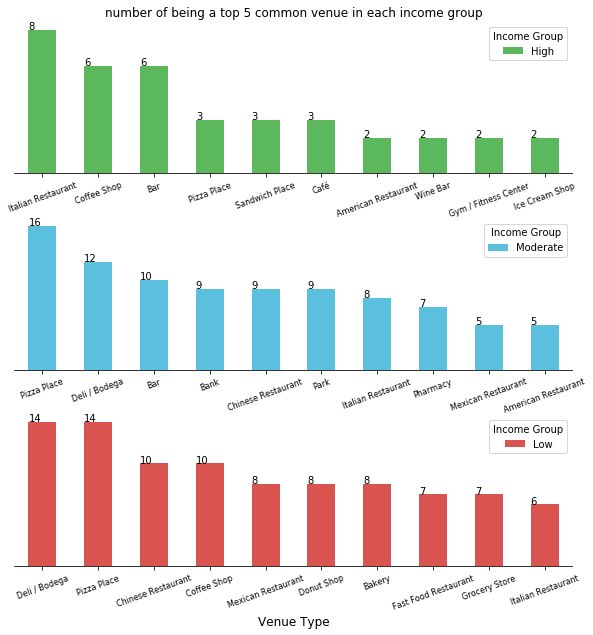

In [350]:
fig = plt.figure() 

ax0 = fig.add_subplot(3, 1, 1) 
ax1 = fig.add_subplot(3, 1, 2) 
ax2 = fig.add_subplot(3, 1, 3)
plt.subplots_adjust(hspace=0.3)

# Subplot 1:
high_income.head(10).plot(kind='bar', figsize=(10, 10), ax=ax0,color = '#5cb85c',fontsize = 8,rot=20) # add to subplot 1
ax0.set_title('number of being a top 5 common venue in each income group')
ax0.set_xlabel('')
ax0.set_ylabel('')
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.spines['left'].set_visible(False)
ax0.get_yaxis().set_ticks([])
for p in ax0.patches:
    ax0.annotate((p.get_height()), (p.get_x() * 0.9999, p.get_height() * 1.005))

# Subplot 2: 
moderate_income.head(10).plot(kind='bar', figsize=(10, 10), ax=ax1, color = '#5bc0de',fontsize = 8,rot=20) # add to subplot 2
ax1.set_xlabel('')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.get_yaxis().set_ticks([])
for p in ax1.patches:
    ax1.annotate((p.get_height()), (p.get_x() * 0.9999, p.get_height() * 1.005))

# Subplot 3: 
low_income.head(10).plot(kind='bar', figsize=(10, 10), ax=ax2, color = '#d9534f',fontsize = 8,rot=20) # add to subplot 3
ax2.set_xlabel('Venue Type',fontsize=12)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.get_yaxis().set_ticks([])
for p in ax2.patches:
    ax2.annotate((p.get_height()), (p.get_x() * 0.9999, p.get_height() * 1.005))

plt.show()

#### 4. Visualize the comparison in a better way

In [316]:
final_df.groupby('Income Group').head(1)

Income Group     Neighborhood        Borough  Median Income in dollar  \
0           Low      Port Morris          Bronx                    20334   
45     Moderate  Queensboro Hill         Queens                    53836   
90         High      Great Kills  Staten Island                    88868   

     Latitude  Longitude 1st Most Common Venue      2nd Most Common Venue  \
0   40.801664 -73.913221      Storage Facility  Latin American Restaurant   
45  40.744572 -73.825809    Chinese Restaurant                Bus Station   
90  40.549480 -74.149324           Pizza Place                        Bar   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
0             Restaurant            Distillery            Donut Shop  
45                  Bank                Bakery        Cosmetics Shop  
90    Italian Restaurant        Sandwich Place              Pharmacy

In [317]:
final_df.groupby('Income Group').tail(1)

Income Group   Neighborhood    Borough  Median Income in dollar  \
44           Low    Murray Hill     Queens                    52696   
89      Moderate       Red Hook   Brooklyn                    85496   
101         High  Carnegie Hill  Manhattan                   155213   

      Latitude  Longitude 1st Most Common Venue 2nd Most Common Venue  \
44   40.748303 -73.978332     Korean Restaurant           Coffee Shop   
89   40.676253 -74.012759    Seafood Restaurant           Art Gallery   
101  40.782683 -73.953256           Coffee Shop           Pizza Place   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
44    Japanese Restaurant                   Bar        Sandwich Place  
89                   Park   American Restaurant                  Café  
101                  Café           Yoga Studio    Italian Restaurant

In [332]:
result = pd.concat([high_income_in_pct.head(10),moderate_income_in_pct.head(10),low_income_in_pct.head(10)],axis=1,sort=False)
result

Income Group          High  Moderate   Low
Italian Restaurant    0.67      0.18  0.13
Coffee Shop           0.50       NaN  0.22
Bar                   0.50      0.22   NaN
Pizza Place           0.25      0.36  0.31
Sandwich Place        0.25       NaN   NaN
Café                  0.25       NaN   NaN
American Restaurant   0.17      0.11   NaN
Wine Bar              0.17       NaN   NaN
Gym / Fitness Center  0.17       NaN   NaN
Ice Cream Shop        0.17       NaN   NaN
Deli / Bodega          NaN      0.27  0.31
Bank                   NaN      0.20   NaN
Chinese Restaurant     NaN      0.20  0.22
Park                   NaN      0.20   NaN
Pharmacy               NaN      0.16   NaN
Mexican Restaurant     NaN      0.11  0.18
Donut Shop             NaN       NaN  0.18
Bakery                 NaN       NaN  0.18
Fast Food Restaurant   NaN       NaN  0.16
Grocery Store          NaN       NaN  0.16

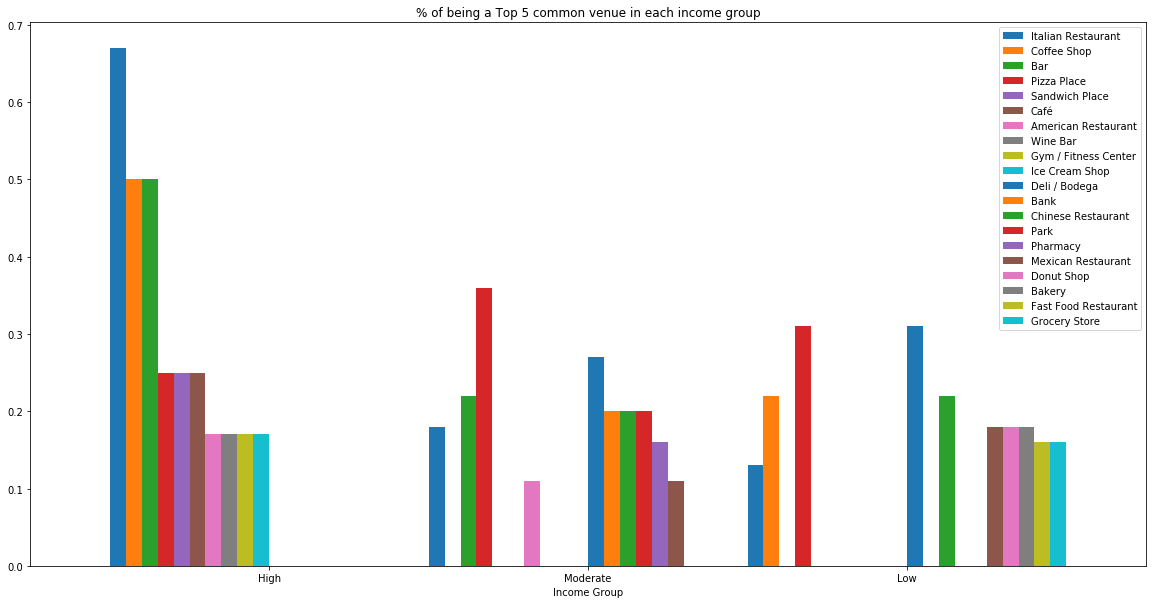

In [346]:
barchart = result.T.plot(kind='bar',figsize=(20,10), width = 1,rot=0)
barchart.set_title('% of being a Top 5 common venue in each income group')
plt.show()

# 4. Create a tool to display where the venues are famous to visit

#### Display the location and group where it is a top 5 common venue of the input venue name

In [448]:
result2 = pd.concat([high_income,moderate_income,low_income],axis=1,sort=False)

def search_fame(venue):
    map_ = folium.Map(location=[latitude, longitude], zoom_start=11)
    x = np.arange(kclusters)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]
    for index, row in final_df.iterrows():
        if venue in final_df.iloc[index,6:11].values:
            markers_colors = []
            real_label = '{0} Group {1}'.format(final_df.iloc[index,1],final_df.iloc[index,0])
            label = folium.Popup(real_label)
            if final_df.iloc[index,0] == 'Low':
                cluster = 0
            elif final_df.iloc[index,0] == 'Moderate':
                cluster = 2
            else:
                cluster = 1
            folium.CircleMarker(
                [final_df.iloc[index,4], final_df.iloc[index,5]],
                radius=5,
                popup=label,
                color=rainbow[cluster-1],
                fill=True,
                fill_color=rainbow[cluster-1],
                fill_opacity=0.7).add_to(map_)
       
    return map_

In [447]:
search_fame('Italian Restaurant')